# AB-тест

**Описание** : Команда ML разработала новый алгоритм рекомендательной постов. На тестовой группе (2) был использован новыый алгоритм. Необходимо проверить гипотезу о том, что новый алгоритм рекомендации постов во 2-й группе приведет к увеличению CTR.


**Задачи** : По данным с '2024-08-02 по 2024-08-08':

1. Расчитать метрику "линеаризованные лайки"
2. Сравнить с помощью t-test значение p-value рассматривая "обычный CTR" и "линеаризованные лайки" для групп (1,2), (0,3)

**Рассмтариваемый показатель** : CTR, линеаризованные лайки
**Используемые методы** : t-test

In [1]:
import pandas as pd
import pandahouse as ph
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats


sns.set_style("whitegrid", {"axes.facecolor": "white"})

## 1 Подготовка данных

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20240820',
'user':'student',
'password':'dpo_python_2020'
}

#текст запроса
query = '''
select user_id, countIf(action='view')  as views, countIf(action='like')  as likes, countIf(action='like')/countIf(action='view') as ctr, exp_group
from simulator_20240820.feed_actions
where toDate(time) between '2024-08-02' and '2024-08-08'  and exp_group in [0,1,2,3]
group by user_id, exp_group
'''

# эта функция выполнит запрос и запишет его результат в pandas DataFrame
df = ph.read_clickhouse(query, connection=connection)

In [3]:
df.head()

,user_id,views,likes,ctr,exp_group
0,115383,44,12,0.272727,3
1,18392,32,7,0.218750,1
2,123580,11,2,0.181818,3
3,131473,108,9,0.083333,2
4,32420,44,13,0.295455,2


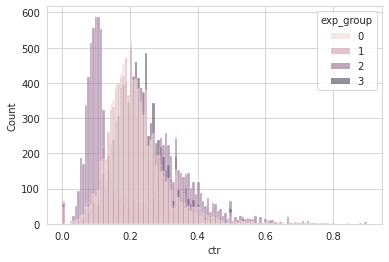

In [4]:
sns.histplot(data=df, x='ctr', hue='exp_group')
plt.show()

## 1.1 Расчёт метрики linearized_likes

In [5]:
# Расчёт глобального CTR

global_ctr1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr0 = df[df.exp_group == 0].likes.sum()/df[df.exp_group == 0].views.sum()

df['global_ctr'] = df['exp_group'].apply(
    lambda x: global_ctr1 if x in [1,2] else global_ctr0)

In [6]:
# Расчёт linearized_likes

df['linearized_likes'] = df['likes'] - df['global_ctr'] * df['views']

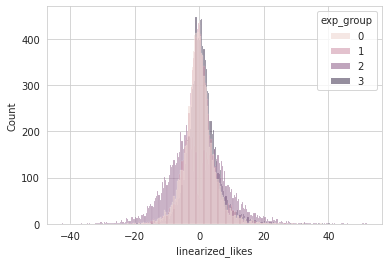

In [7]:
# Распределение linearized_likes

sns.histplot(data=df, x='linearized_likes', hue='exp_group')
plt.show()

In [8]:
df.groupby('exp_group')['ctr', 'linearized_likes'].agg(['mean', 'median'])

/tmp/ipykernel_399/949315969.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('exp_group')['ctr', 'linearized_likes'].agg(['mean', 'median'])


ctr           linearized_likes          
               mean    median             mean    median
exp_group                                               
0          0.216858  0.205357     8.022257e-17 -0.219793
1          0.216774  0.205882    -2.691127e-16 -0.157041
2          0.216102  0.153285    -6.245119e-01 -1.724854
3          0.233192  0.222222     1.094844e+00  0.642592

## 2 Анализ linearized_likes и CTR в двух группах

### Формирование гипотез:
- H0: linearized_likes контрольной группы и linearized_likes эспериментальной группы не различаются 
- H1: linearized_likes контрольной группы и linearized_likes эспериментальной группы различаются

### 2.1 t-test групп (0,3)

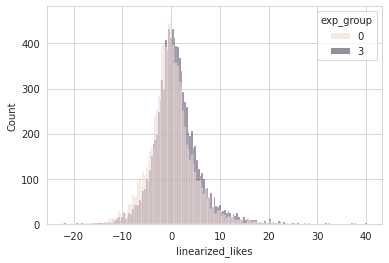

In [13]:
sns.histplot(data=df[df.exp_group.isin([0,3])], x='linearized_likes', hue='exp_group')
plt.show()

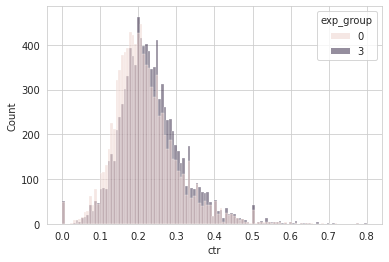

In [15]:
sns.histplot(data=df[df.exp_group.isin([0,3])], x='ctr', hue='exp_group')
plt.show()

In [9]:
pvalue_ttest_ctr_03 = stats.ttest_ind(df[df.exp_group == 0]['ctr'], df[df.exp_group == 3]['ctr'], equal_var=False).pvalue
pvalue_ttest_linlike_03 = stats.ttest_ind(df[df.exp_group == 0]['linearized_likes'], df[df.exp_group == 3]['linearized_likes'], equal_var=False).pvalue
pd.DataFrame([['CTR', pvalue_ttest_ctr_03], ['linearized_likes',pvalue_ttest_linlike_03]] ,columns=['metrics', 'pvalue'])

,metrics,pvalue
0,CTR,6.216047e-44
1,linearized_likes,1.491814e-58


**Вывод**: тест между группами 0 и 3 по метрике линеаризованных лайков показал снижение p-value по-сравнению с обычным CTR

### 2.1 t-test групп (1,2)

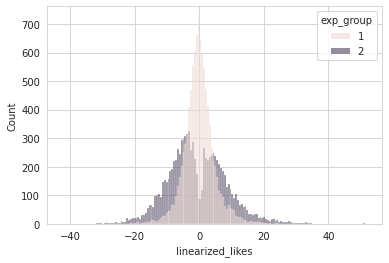

In [14]:
sns.histplot(data=df[df.exp_group.isin([1,2])], x='linearized_likes', hue='exp_group')
plt.show()

In [10]:
pvalue_ttest_ctr_12 = stats.ttest_ind(df[df.exp_group == 1]['ctr'], df[df.exp_group == 2]['ctr'], equal_var=False).pvalue
pvalue_ttest_linlike_12 = stats.ttest_ind(df[df.exp_group == 1]['linearized_likes'], df[df.exp_group == 2]['linearized_likes'], equal_var=False).pvalue
pd.DataFrame([['CTR', pvalue_ttest_ctr_12], ['linearized_likes',pvalue_ttest_linlike_12]] ,columns=['metrics', 'pvalue'])

,metrics,pvalue
0,CTR,6.853733e-01
1,linearized_likes,2.980506e-09


In [11]:
pvalue__ttest_smoothed_ctr = stats.ttest_ind(df[df.exp_group == 1]['smothed_ctr'], df[df.exp_group == 2]['smothed_ctr'], equal_var=False).pvalue

KeyError: 'smothed_ctr'

In [ ]:
pvalue_Mann_smoothed_ctr = stats.mannwhitneyu(df[df.exp_group == 1]['smothed_ctr'], df[df.exp_group == 2]['smothed_ctr']).pvalue

**Вывод**: тест между группами 1 и 2 по метрике линеаризованных лайков показал снижение p-value по-сравнению с обычным CTR. При анализе метрики линеаризованных лайков, можно отвергнуть гипотезу о равенстве этих метрик в контрольной и тестовой группе. Различия от обычного CTR обусловлено изменением харакетера распределения 